# README

* Use window based sequences
* Enable Keras stateful in model training

In [1]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
original_features=['scalar.fx', 'scalar.fy', 'scalar.fz','scalar.tx', 'scalar.ty','scalar.tz','scalar.current','scalar.ang_vel']

# Load data

## load window-based data

In [3]:
%%time
frames = 32
steps = 8

import os.path
file_path = 'data_win/f32s8.npz'
if os.path.exists(file_path):
    loaded = np.load(file_path)
    X = loaded['X']
    Y = loaded['Y']
    Y2 = loaded['Y2']
else:
    X, Y, Y2 = moving_windows(dfs, frames, steps)
    np.savez_compressed(file_path, X=X, Y=Y, Y2=Y2)

CPU times: user 4.16 s, sys: 188 ms, total: 4.35 s
Wall time: 4.34 s


#### Plot a histogram of types

(array([      0.,  433720.,   82458.,   21594.,    3516.,    2264.,
           6397.,    3243.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

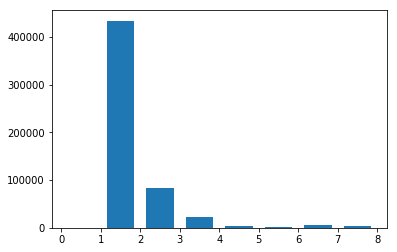

In [4]:
plt.hist(Y, bins=np.arange(len(np.unique(Y))+2), rwidth=.7, align='mid')

In [5]:
np.unique(Y)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.])

#### Plot a histogram of stages

(array([  42954.,   24250.,   30095.,   76401.,  322035.,   10290.,
           2103.,     952.,    2786.,   41326.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

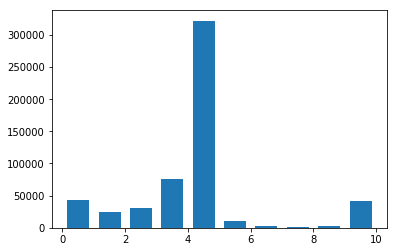

In [6]:
plt.hist(Y2, bins=np.arange(len(np.unique(Y2))+1), rwidth=.7, align='mid')

In [7]:
np.unique(Y2)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# One hot encoding of dependent variables

In [8]:
offset = 1
num_classes = len(np.unique(Y))
Y_encoded=to_categorical(Y-offset, num_classes=num_classes)
Y_encoded.shape

(553192, 7)

In [9]:
offset = 0
num_classes = len(np.unique(Y2))
Y2_encoded=to_categorical(Y2, num_classes=num_classes)
Y2_encoded.shape

(553192, 10)

# Split the data to train, validation and test

* train = 60% + 53 # to make the number of training data a multiple of batch_size (64)
* validation = 20% + 7 # to make it dividable by 64
* test = validation # to make it dividable by 64

In [93]:
x_train, x_validate, x_test = np.split(X, [int(.6*len(X))+53, int(.8*len(X))+7])
y_train, y_validate, y_test = np.split(Y_encoded, [int(.6*len(Y_encoded))+53, int(.8*len(Y_encoded))+7])
y2_train, y2_validate, y2_test = np.split(Y2_encoded, [int(.6*len(Y2_encoded))+53, int(.8*len(Y2_encoded))+7])

x_test = x_test[0:len(x_validate)]
y_test = y_test[0:len(x_validate)]
y2_test = y2_test[0:len(x_validate)]

print (x_train.shape, y_train.shape, y2_train.shape)
print (x_validate.shape, y_validate.shape, y2_validate.shape)
print (x_test.shape, y_test.shape, y2_test.shape)

((331968, 32, 8), (331968, 7), (331968, 10))
((110592, 32, 8), (110592, 7), (110592, 10))
((110592, 32, 8), (110592, 7), (110592, 10))


### Histogram of classes in training data

(array([ 259794.,   47704.,   13477.,    2275.,    1808.,    4118.,    2792.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

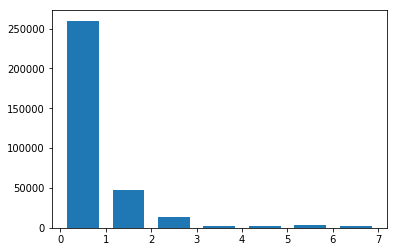

In [62]:
labels=np.argmax(y_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

(array([  25840.,   15718.,   18270.,   43892.,  193211.,    6269.,
           1670.,     605.,    1739.,   24754.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

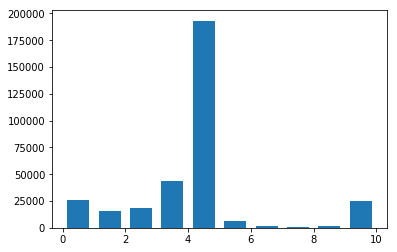

In [63]:
labels=np.argmax(y2_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

# Train a type classification model with LSTM

* stateful=True
* shuffle=False
* An important difference in training the stateful LSTM is that we train it manually one epoch at a time and reset the state after each epoch. We can do this in a for loop. Again, we do not shuffle the input, preserving the sequence in which the input training data was created.

In [ ]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 10
batch_size = 64
num_classes = y_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim),
               stateful=True, batch_size=batch_size), 
         LSTM(batch_size, return_sequences=True, stateful=True),
         LSTM(batch_size, stateful=True),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# checkpoint
filepath="models/type_lstm_v3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_arr = []
for i in range(num_epochs):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=1,
                        validation_data=(x_validate, y_validate),
                        callbacks=callbacks_list,
                        shuffle=False)
    history_arr.append(history)
    model.reset_states()

Train on 331968 samples, validate on 110592 samples
Epoch 1/1
331968/331968 [==============================] - 325s 980us/step - loss: 0.3003 - acc: 0.9277 - val_loss: 1.8009 - val_acc: 0.8138
Train on 331968 samples, validate on 110592 samples
Epoch 1/1
331968/331968 [==============================] - 325s 978us/step - loss: 0.2797 - acc: 0.9339 - val_loss: 1.8851 - val_acc: 0.8138
Train on 331968 samples, validate on 110592 samples
Epoch 1/1
331968/331968 [==============================] - 325s 979us/step - loss: 0.3013 - acc: 0.9282 - val_loss: 1.8335 - val_acc: 0.8138
Train on 331968 samples, validate on 110592 samples
Epoch 1/1
331968/331968 [==============================] - 325s 978us/step - loss: 0.3722 - acc: 0.9264 - val_loss: 1.6153 - val_acc: 0.8157
Train on 331968 samples, validate on 110592 samples
Epoch 1/1
331968/331968 [==============================] - 325s 979us/step - loss: 0.4656 - acc: 0.9247 - val_loss: 1.8636 - val_acc: 0.8140
Train on 331968 samples, validate o

## View training history

In [101]:
def plot_history(history_arr):
    # flatten the array
    history = {
        'acc': [], 'val_acc':[], 'loss':[], 'val_loss':[]
    }
    for h in history_arr:
        history['acc'].extend(h.history['acc'])
        history['val_acc'].extend(h.history['val_acc'])
        history['loss'].extend(h.history['loss'])
        history['val_loss'].extend(h.history['val_loss'])

    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

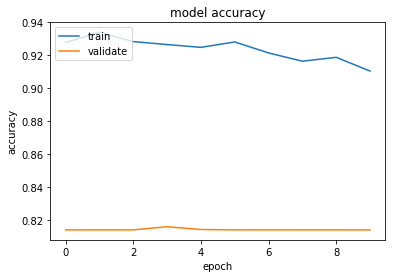

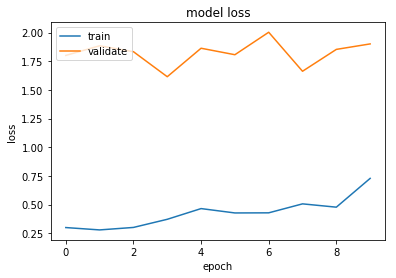

In [102]:
plot_history(history_arr)

## Save the model
include the model and its weights

In [67]:
def save_model(model, model_filename="models/type_lstm_v3.json", weights_file_name=None):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_filename, "w") as json_file:
        json_file.write(model_json)
    print("Saved the model to disk")    
    
    # serialize weights to HDF5
    if weights_file_name is not None:
        model.save_weights(weights_file_name)
        print("Saved the model weights to disk")

In [70]:
save_model(model, "models/type_lstm_v3.json")

Saved the model to disk


## Use the saved model to predict on new data

In [68]:
def load_model(model_filename='models/type_lstm_v2.json', weights_filename="models/type_lstm_v2.h5"):
    # load json and create model
    json_file = open(model_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_filename)
    print("Loaded the model from disk")
    
    return loaded_model

In [140]:
model = load_model('models/type_lstm_v3.json', "models/type_lstm_v3.h5")

Loaded the model from disk


## We need to compile the model before use it

In [141]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [117]:
model.metrics_names

['loss', 'acc']

In [142]:
def evaluate(x_test, y_test, batch_size=64):
    x_test_arr=np.split(x_test, len(x_test)/batch_size)
    y_test_arr=np.split(y_test, len(y_test)/batch_size)
    scores=np.zeros((len(x_test_arr), 2))
    for i in np.arange(len(x_test_arr)):
        x = x_test_arr[i]
        y = y_test_arr[i]
        score = model.evaluate(x, y, batch_size=batch_size)
        model.reset_states()
        scores[i][0] = score[0]
        scores[i][1] = score[1]
    return scores.mean(axis=0)

In [143]:
score = evaluate(x_test, y_test)

64/64 [==============================] - 0s 251us/step


64/64 [==============================] - 0s 246us/step


64/64 [==============================] - 0s 247us/step


64/64 [==============================] - 0s 247us/step


64/64 [==============================] - 0s 245us/step


64/64 [==============================] - 0s 254us/step


64/64 [==============================] - 0s 256us/step


64/64 [==============================] - 0s 254us/step


64/64 [==============================] - 0s 250us/step


64/64 [==============================] - 0s 331us/step


64/64 [==============================] - 0s 247us/step


64/64 [==============================] - 0s 246us/step


In [144]:
score

array([ 1.89511177,  0.75185366])

## Predict

**Remember** The classes are 0 to 6 instead of 1 to 7.

In [170]:
%%time
y_hat = model.predict(x_test, batch_size=64)

In [171]:
x_test.shape

(110592, 32, 8)

### Prediction results are the probability of each class

In [172]:
y_hat.shape

(110592, 10)

In [173]:
y_hat

array([[  1.47047947e-04,   2.48495235e-06,   4.85170540e-06, ...,
          1.84886673e-09,   6.77710288e-09,   4.77398225e-06],
       [  3.70637048e-04,   4.23768233e-06,   1.51593067e-05, ...,
          5.54322988e-09,   1.98442560e-08,   9.08451057e-06],
       [  2.86754512e-04,   3.69304325e-06,   1.82210133e-05, ...,
          3.84799659e-09,   1.33081217e-08,   8.04446881e-06],
       ..., 
       [  2.00920069e-04,   2.45716423e-04,   1.56330096e-03, ...,
          5.53894949e-07,   3.29181739e-06,   2.43628072e-03],
       [  4.04254497e-05,   1.19343604e-04,   5.31057827e-04, ...,
          1.09623102e-07,   5.48854132e-07,   3.83247680e-04],
       [  5.10286918e-05,   1.19305732e-04,   6.51936629e-04, ...,
          1.79329419e-07,   8.80472385e-07,   8.48612341e-04]], dtype=float32)

# Train a stage classification model with LSTM

In [ ]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 10
batch_size = 64
num_classes = y2_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim),
               stateful=True, batch_size=batch_size), 
         LSTM(batch_size, return_sequences=True, stateful=True),
         LSTM(batch_size, stateful=True),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# checkpoint
filepath="models/stage_lstm_v3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_stage_arr = []
for i in range(num_epochs):
    history = model.fit(x_train, y2_train,
                        batch_size=batch_size, epochs=1,
                        validation_data=(x_validate, y2_validate),
                        callbacks=callbacks_list,
                        shuffle=False)
    history_stage_arr.append(history)
    model.reset_states()

## View training history

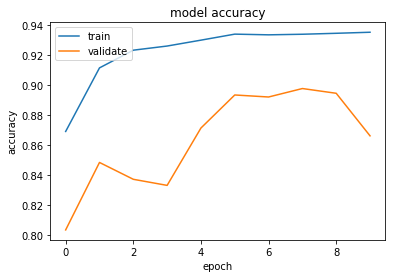

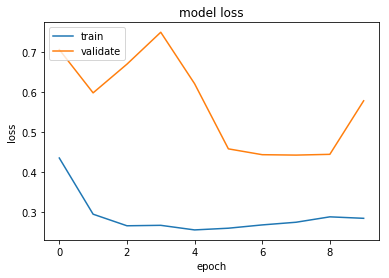

In [103]:
plot_history(history_stage_arr)

## Save the model - network structure

In [80]:
save_model(model, "models/stage_lstm_v3.json")

Saved the model to disk


## Use the saved model to predict on new data

In [145]:
model = load_model('models/stage_lstm_v3.json', "models/stage_lstm_v3.h5")

Loaded the model from disk


## We need to compile the model before use it

In [146]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [135]:
model.metrics_names

['loss', 'acc']

In [178]:
score = evaluate(x_test, y2_test, batch_size=64)

64/64 [==============================] - 0s 276us/step


64/64 [==============================] - 0s 275us/step


64/64 [==============================] - 0s 257us/step


64/64 [==============================] - 0s 249us/step


64/64 [==============================] - 0s 255us/step


64/64 [==============================] - 0s 253us/step


64/64 [==============================] - 0s 249us/step


64/64 [==============================] - 0s 254us/step


64/64 [==============================] - 0s 247us/step


64/64 [==============================] - 0s 261us/step


64/64 [==============================] - 0s 251us/step


64/64 [==============================] - 0s 247us/step


In [148]:
score

array([ 0.86421055,  0.85119177])

## Predict

In [174]:
%%time
y_hat = model.predict(x_test, batch_size=64)

CPU times: user 28.3 s, sys: 534 ms, total: 28.8 s
Wall time: 26.5 s


In [175]:
x_test.shape

(110592, 32, 8)

### Prediction results are the probability of each class

In [176]:
y_hat.shape

(110592, 10)

In [177]:
y_hat

array([[  1.01448524e-04,   7.68235041e-05,   1.21222336e-04, ...,
          4.94949646e-08,   2.58989303e-07,   3.30414885e-04],
       [  1.45226135e-04,   1.61752090e-04,   2.00618393e-04, ...,
          1.67429377e-07,   7.78936339e-07,   1.27348304e-03],
       [  1.11022855e-04,   1.91617088e-04,   2.14141575e-04, ...,
          1.68377881e-07,   8.57796124e-07,   1.10119791e-03],
       ..., 
       [  2.00919676e-04,   2.45716190e-04,   1.56330015e-03, ...,
          5.53893926e-07,   3.29181125e-06,   2.43627722e-03],
       [  4.04255297e-05,   1.19343727e-04,   5.31058584e-04, ...,
          1.09623315e-07,   5.48855724e-07,   3.83248203e-04],
       [  5.10286409e-05,   1.19305732e-04,   6.51935698e-04, ...,
          1.79329248e-07,   8.80471589e-07,   8.48612341e-04]], dtype=float32)